# 04 - Billboard Exploratory Data Analysis
In this notebook, we focus on EDA from only the Billboard Year-end Top 100 charts.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

from matplotlib import rcParams
from matplotlib.patches import Rectangle
from scipy.stats import relfreq

sns.set(context='poster', style='white')
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = 'arial'

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

## Load data
Load data scraped, cleaned, and combined in previous 3 notebooks.

In [2]:
df = pd.read_csv('../data/billboard-lyrics-spotify.csv')
df.sample(3)

,rank,song,artist_base,artist_all,year,artist_featured,song_clean,artist_clean,lyrics,acousticness,...,speechiness,tempo,time_signature,valence,duration_min,num_words,words_per_sec,num_uniq_words,decade,uniq_ratio
3147,57,just between you and me,lou gramm,lou gramm,1990,NaN,just between you and me,lou gramm,staring at each other with accusing eyes keep ...,0.1430,...,0.0262,121.519,4.0,0.878,4.846000,393.0,1.351630,121.0,1990,3.247934
4740,64,keep holding on,avril lavigne,avril lavigne,2007,NaN,keep holding on,avril lavigne,youre not alone together we stand ill be by y...,0.0374,...,0.0333,161.061,3.0,0.146,3.998450,340.0,1.417216,89.0,2000,3.820225
4322,11,get low,lil jon,lil jon & the east side boyz featuring ying ...,2003,ying yang twins,get low,lil jon,brrr dum dum dum dum da da da da dum brrr dum ...,0.0297,...,0.0376,101.007,4.0,0.154,5.567783,912.0,2.729991,207.0,2000,4.405797


## Most popular artists

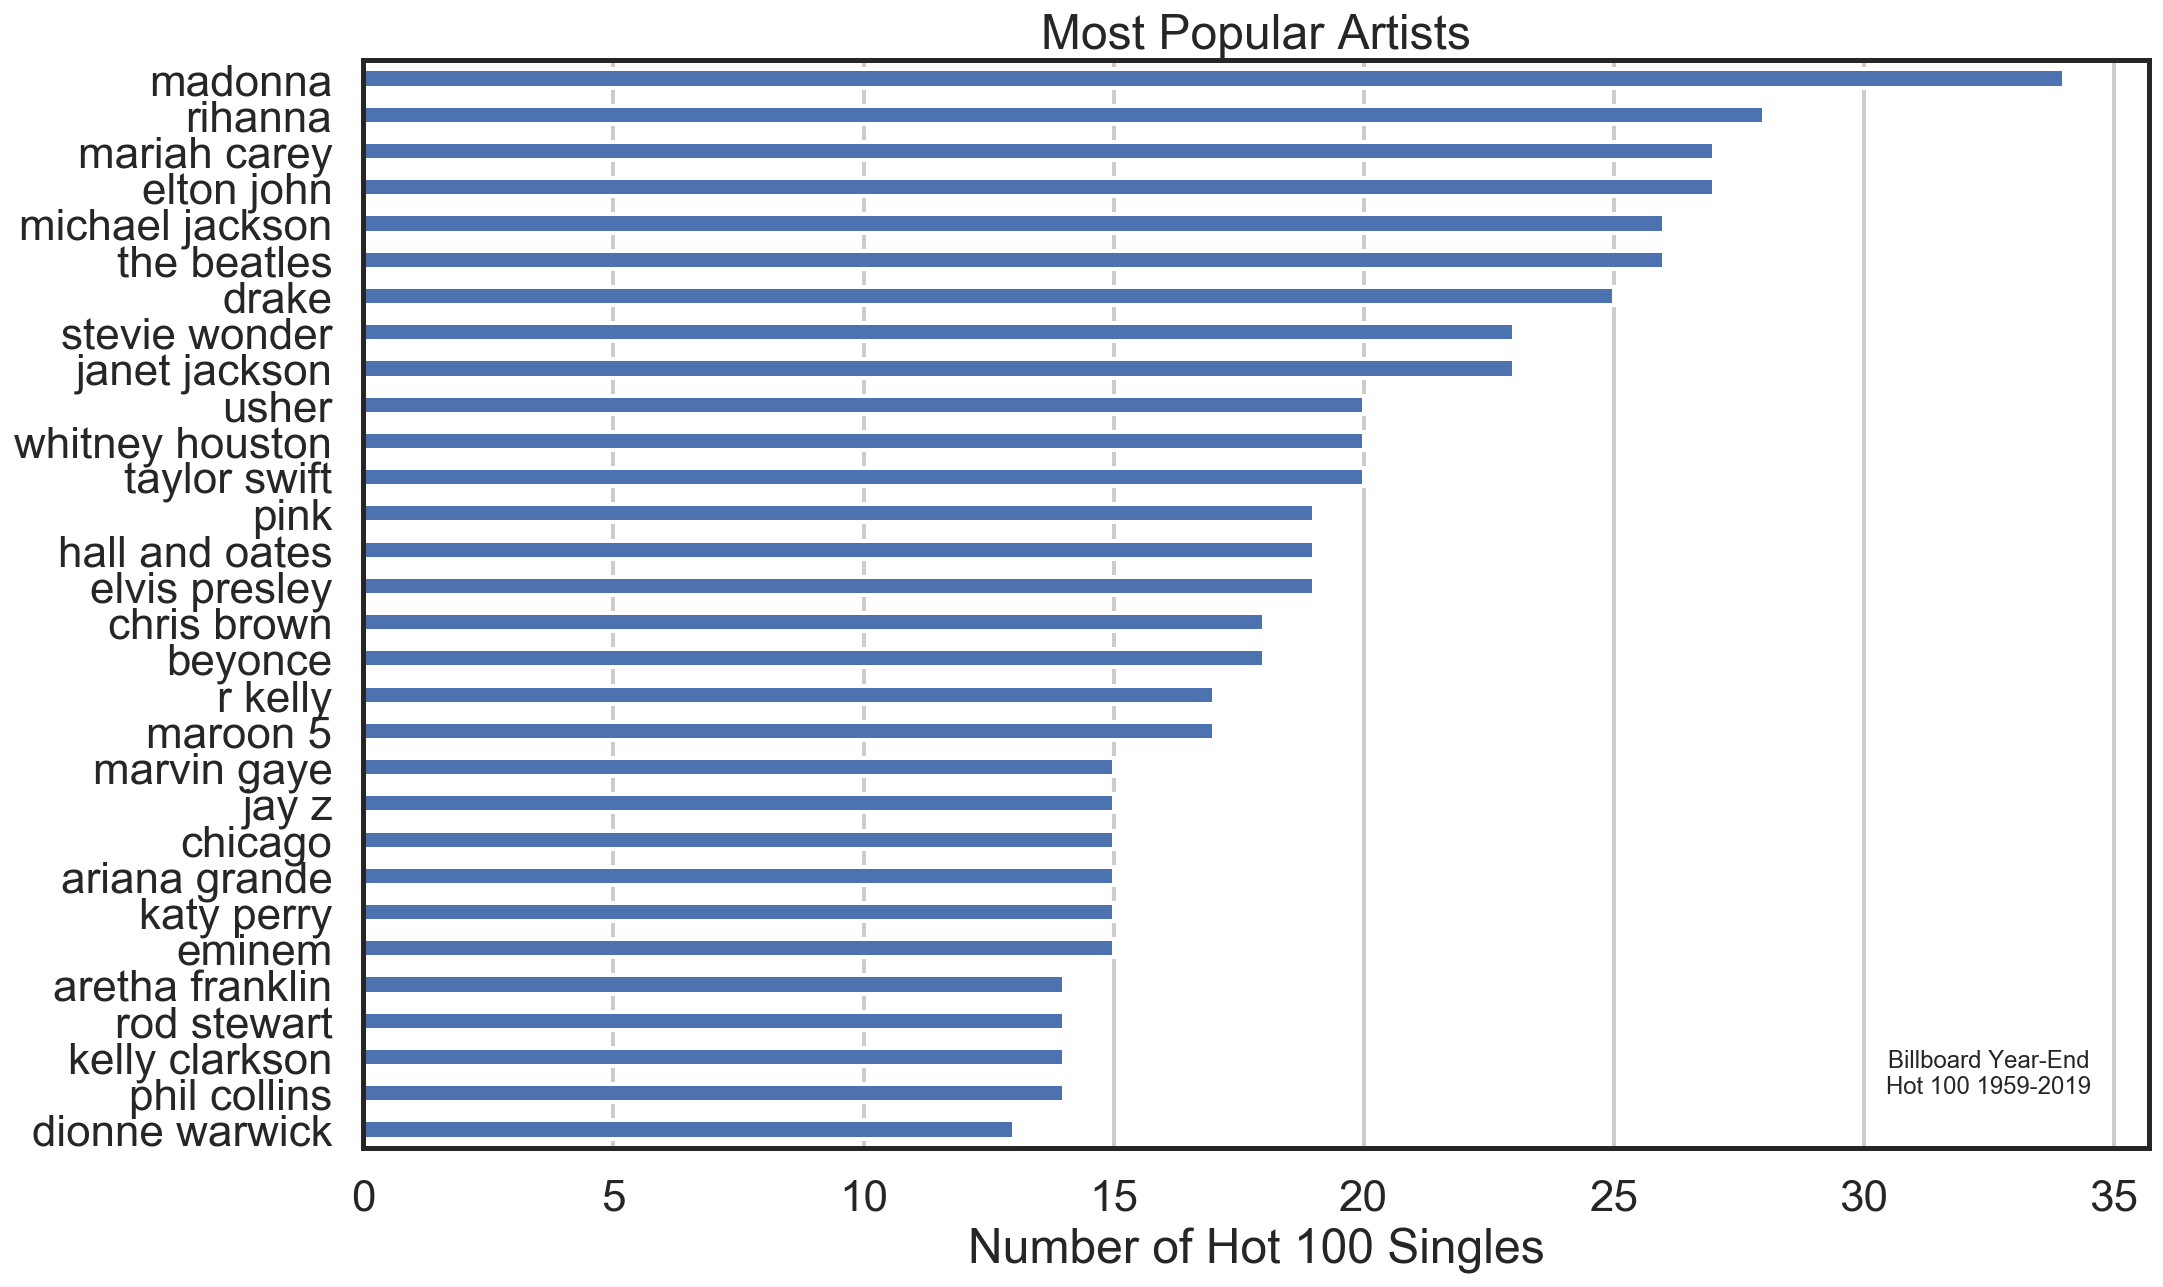

In [3]:
ax = df['artist_clean'].value_counts().sort_values().tail(30)\
                       .plot.barh(figsize=(16,10))
ax.xaxis.grid(True)
ax.set(xlabel='Number of Hot 100 Singles')
ax.set_title('Most Popular Artists', fontsize=24)
ax.annotate('Billboard Year-End\nHot 100 1959-2019', xy=(32.5,1),
            fontsize=12, ha='center')

## Artist diversity over time

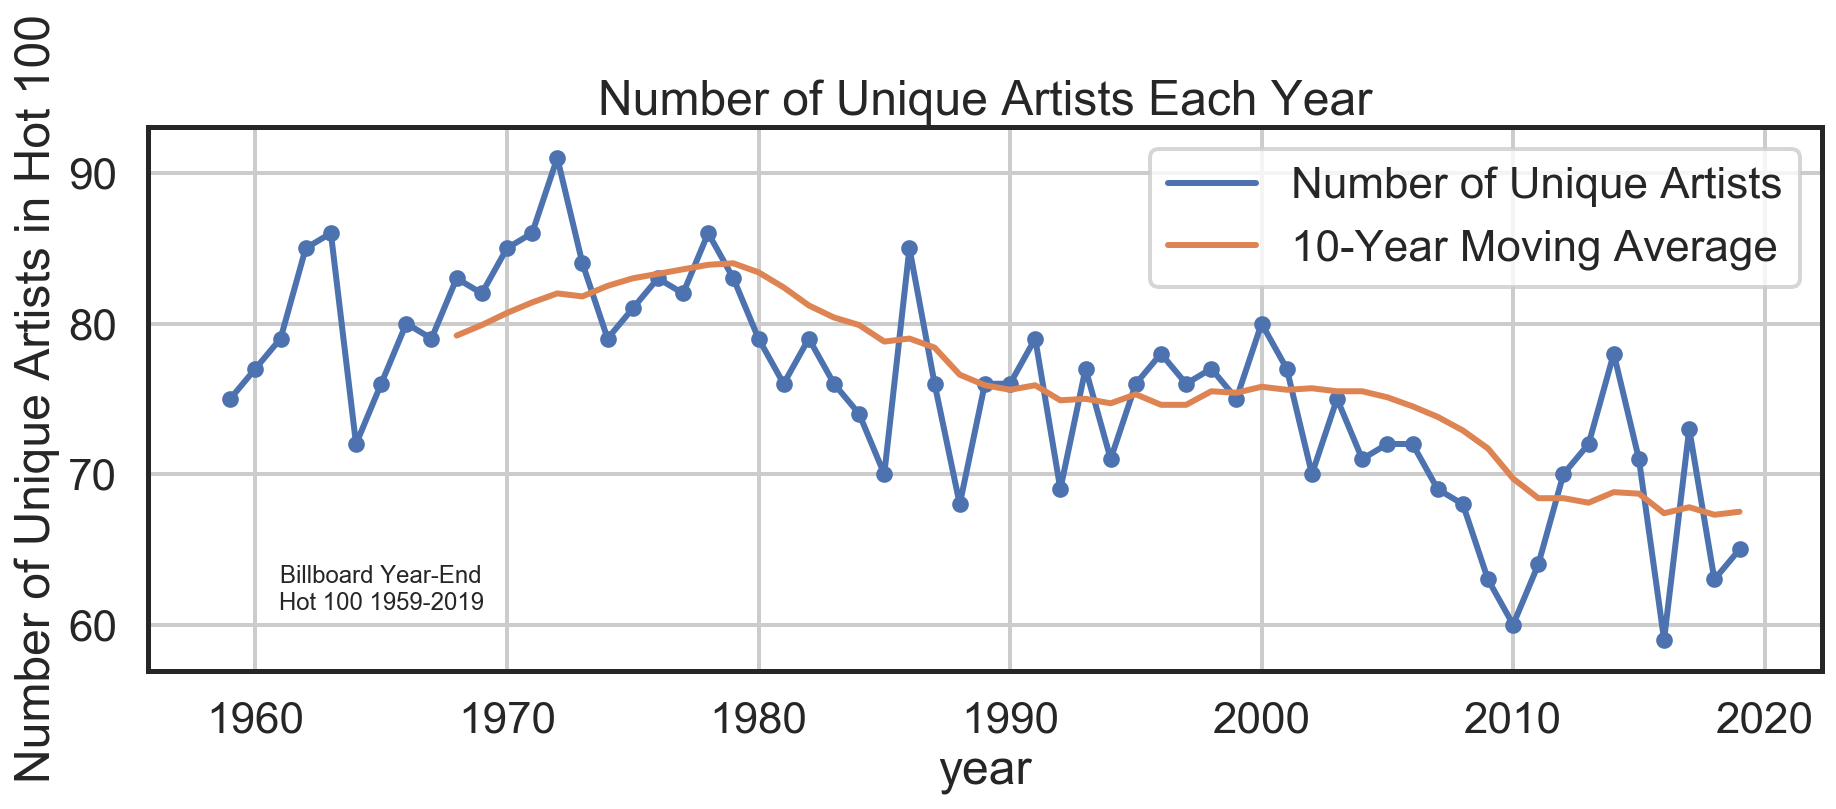

In [4]:
# calculate number of unique artists for each year
nunique_artists_year = df.groupby(['year'])['artist_clean'].agg(pd.Series.nunique)

# generate line plot and augment with points
ax = nunique_artists_year.plot.line(figsize = (15,5), grid=True, label='# unique artists')
ax.scatter(nunique_artists_year.index, nunique_artists_year, s=40)
ax.set(ylabel='Number of Unique Artists in Hot 100',
       title='Number of Unique Artists Each Year')

# denoise with a 10-year moving average
nunique_artists_year.rolling(window=10).mean().plot(
    grid=True, label='10-year moving average')
ax.annotate('Billboard Year-End\nHot 100 1959-2019', xy=(1965,61),
            fontsize=12, ha='center')
plt.legend(['Number of Unique Artists', '10-Year Moving Average']);

## Artist collaboration over time

Text(1962, 1.5, 'Billboard Year-End\nHot 100 1959-2019')

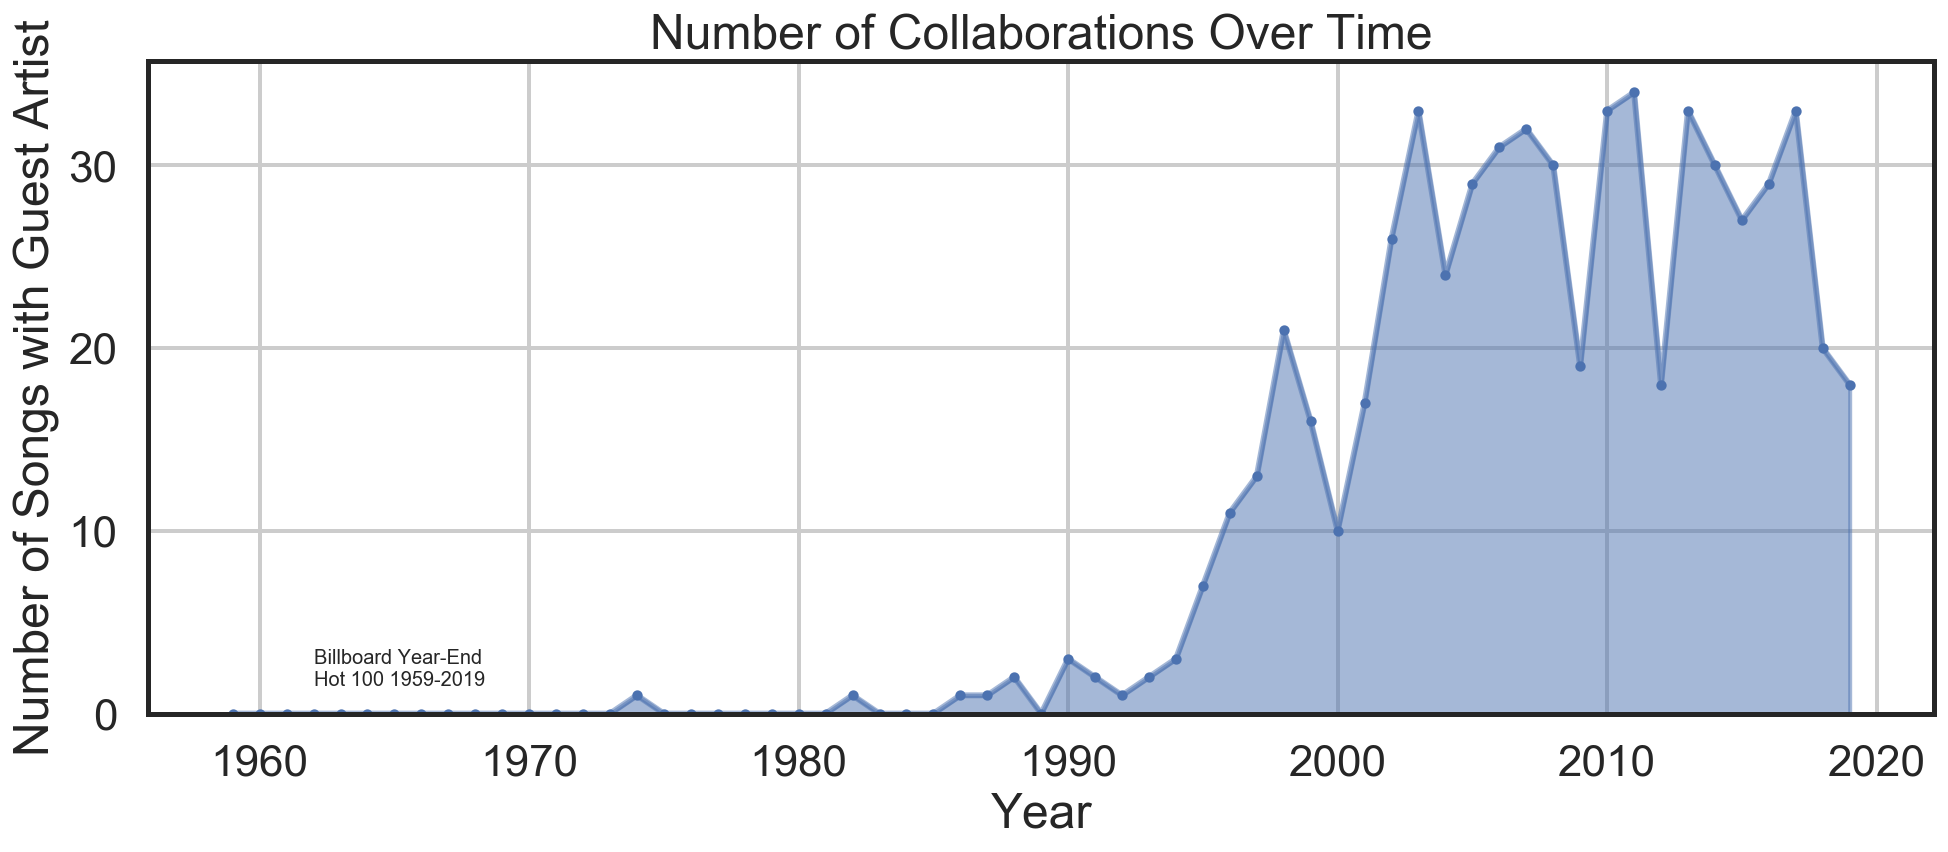

In [5]:
# collaboration counted if artist name contains "featuring"
df_collab = df[df['artist_all'].str.contains('featuring')]
df_collab = df_collab.groupby(['year'])['artist_clean']\
                     .count().reindex(range(1959, 2020))
df_collab = df_collab.fillna(0)

# generate line plot and augment with points
ax = df_collab.plot.area(figsize=(16,6), grid=True, alpha=0.5)
ax.scatter(df_collab.index, df_collab, s=10)
ax.set(ylabel='Number of Songs with Guest Artist',
       xlabel='Year',
       title='Number of Collaborations Over Time');
ax.annotate('Billboard Year-End\nHot 100 1959-2019',
            xy=(1962,1.5))

## Most featuring and most featured artists

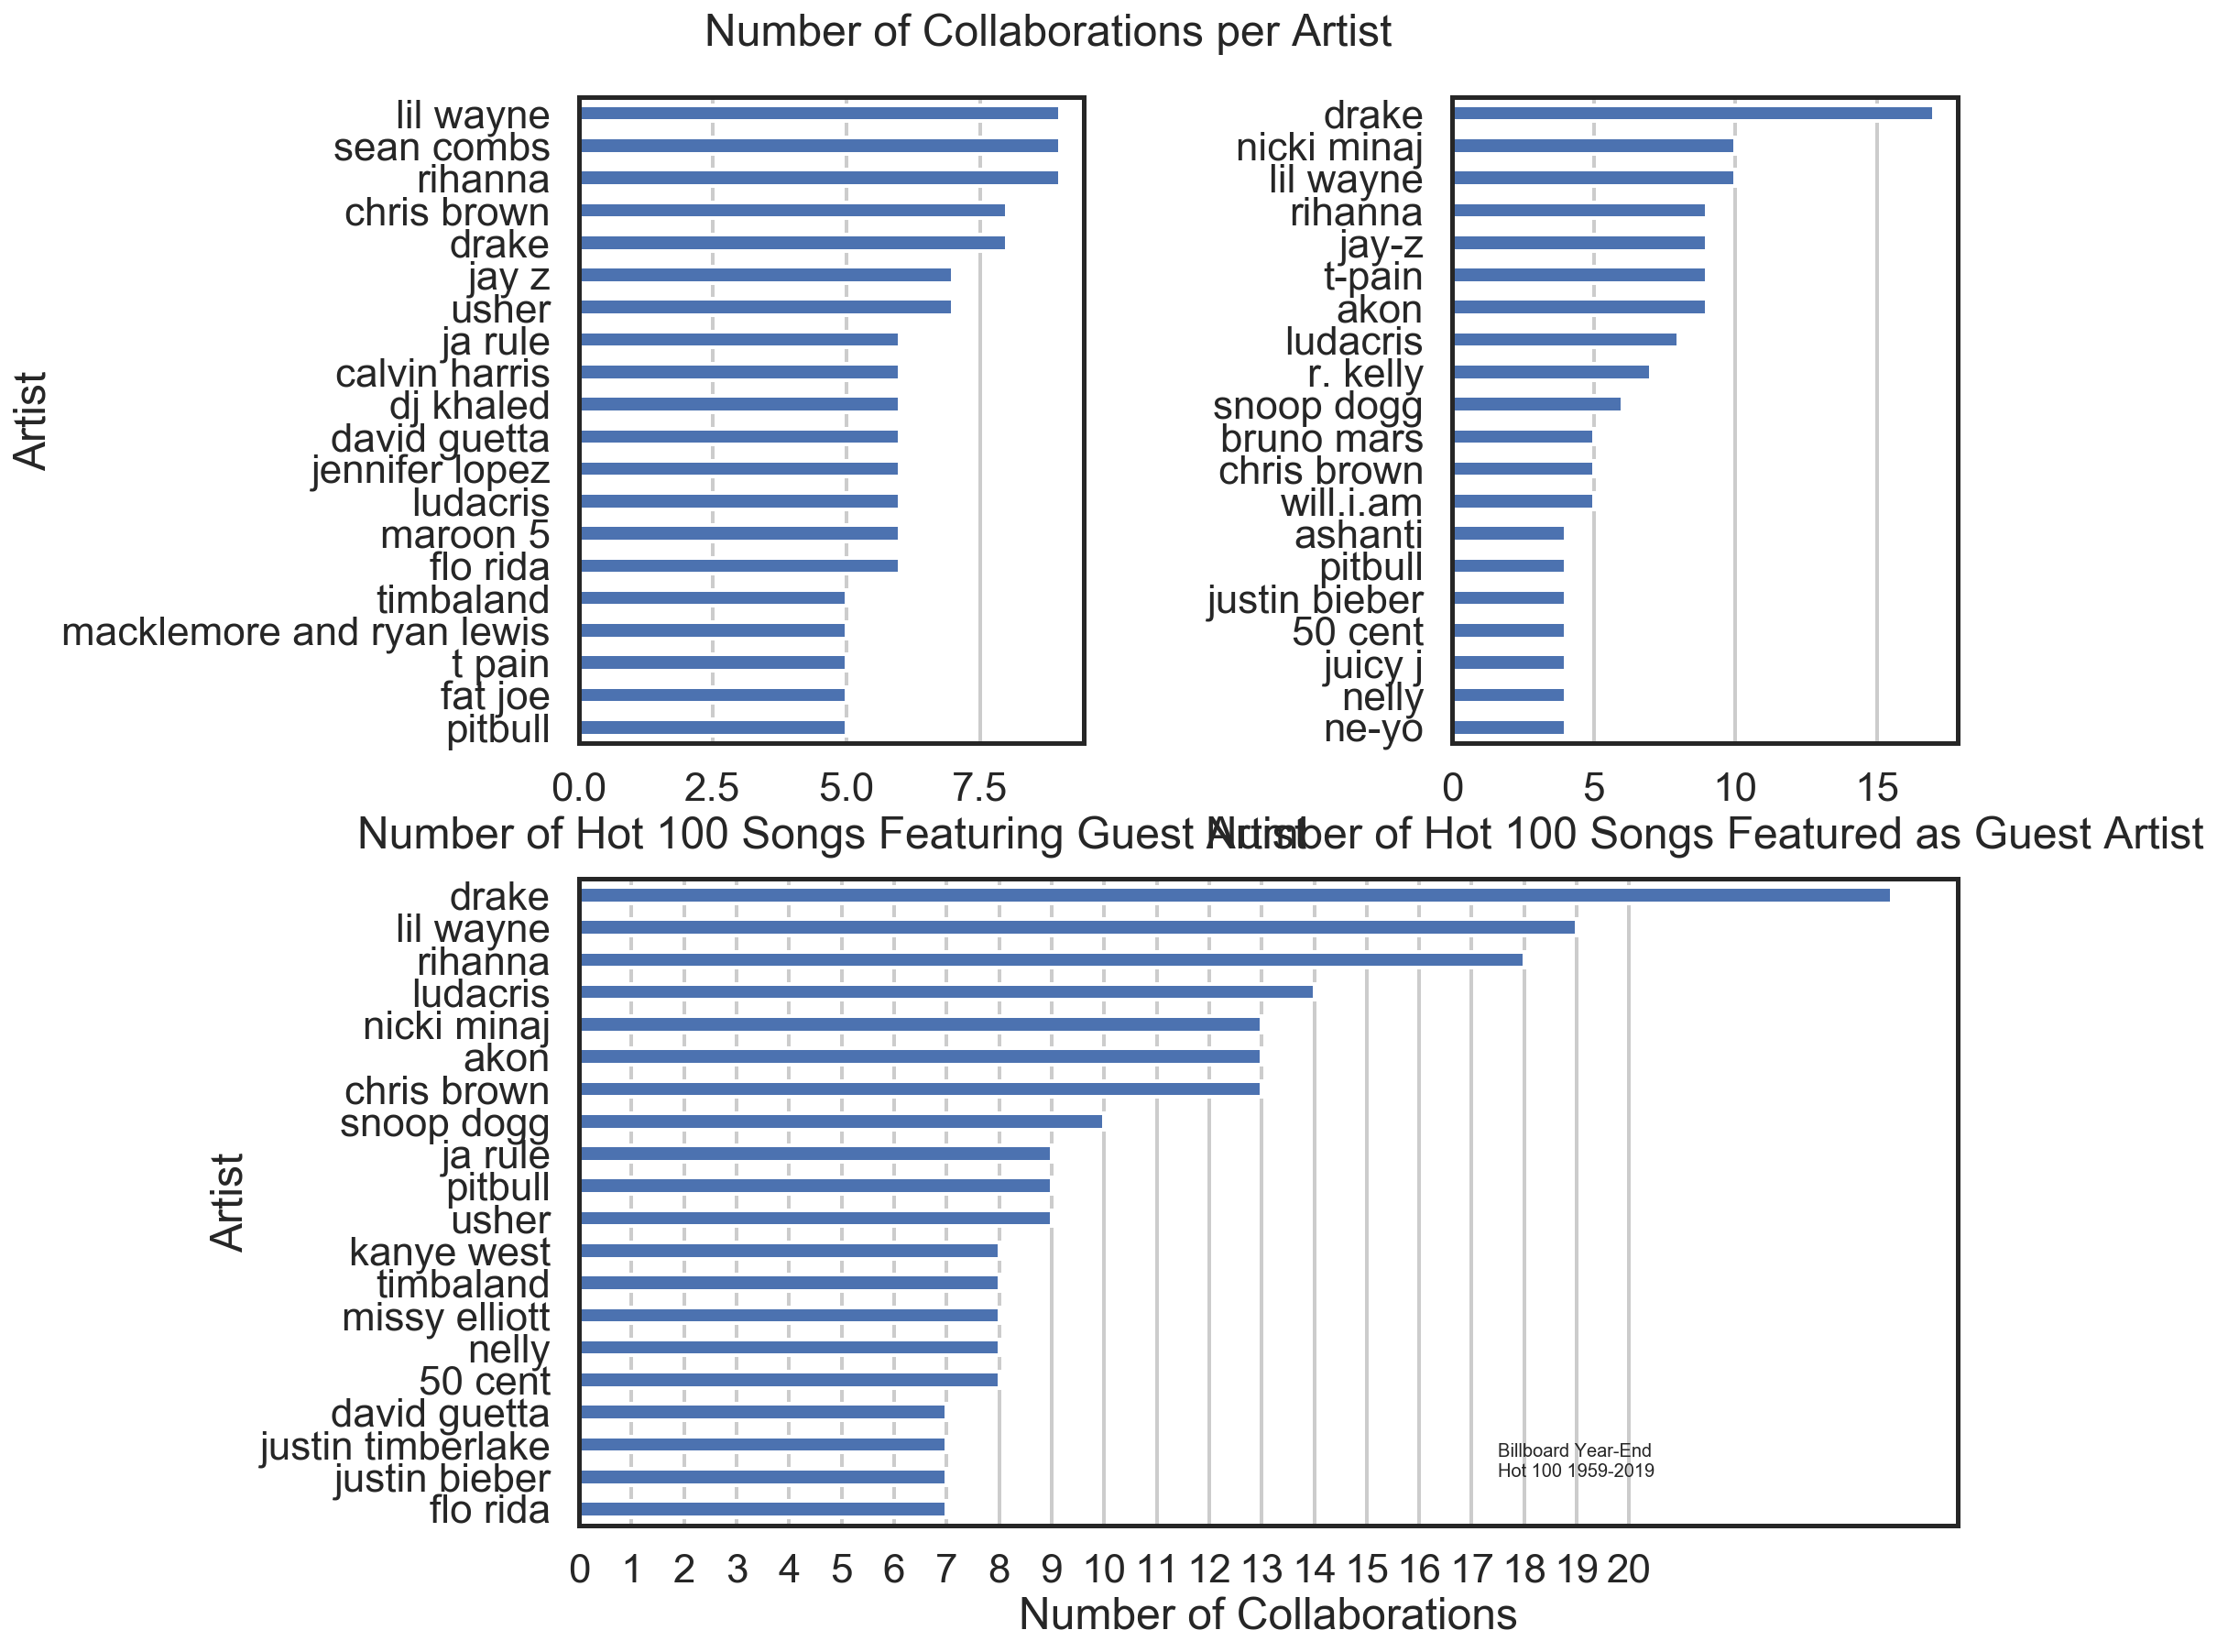

In [7]:
# generate subplots
axes = list()
plt.figure(figsize=(16,12))
grid_positions = [221, 222, 212]
for position in grid_positions:
    axes.append(plt.subplot(position))

# calculate "featuring" vs "featured" stats for each artist
featuring = df.groupby('artist_clean')['artist_featured'].count()
featured = df['artist_featured'].value_counts()

# generate upper two plots
featuring.sort_values().tail(20).plot.barh(ax=axes[0])
featured.sort_values().tail(20).plot.barh(ax=axes[1])
axes[0].set(xlabel = 'Number of Hot 100 Songs Featuring Guest Artist',
            ylabel = 'Artist')
axes[1].set(xlabel = 'Number of Hot 100 Songs Featured as Guest Artist')

# indices must be reset for merging by artist
featuring = featuring.reset_index()
featured = featured.reset_index()
merged = pd.merge(featuring, featured, how='inner', left_on='artist_clean',
                  right_on='index')
merged = merged.drop('index', axis=1)

# calculate number of collborations from "featuring" and "featured" stats
merged.columns = ['artist', 'n_featuring', 'n_featured']
merged['n_collab'] = merged['n_featuring'] + merged['n_featured']
merged = merged.set_index('artist') # for yticklabels when plotting

# generate lower plot
axes[2] = merged['n_collab'].sort_values().tail(20).plot.barh()
axes[2].set(xlabel='Number of Collaborations', ylabel='Artist')
axes[2].set_xticks(range(0,21,1));
axes[2].annotate('Billboard Year-End\nHot 100 1959-2019',
    xy=(17.5,1))

# final touches
for ax in axes:
    ax.xaxis.grid(True)
plt.tight_layout()
plt.suptitle('Number of Collaborations per Artist', fontsize=24, y=1.04)

## Artist collaboration networks

No handles with labels found to put in legend.


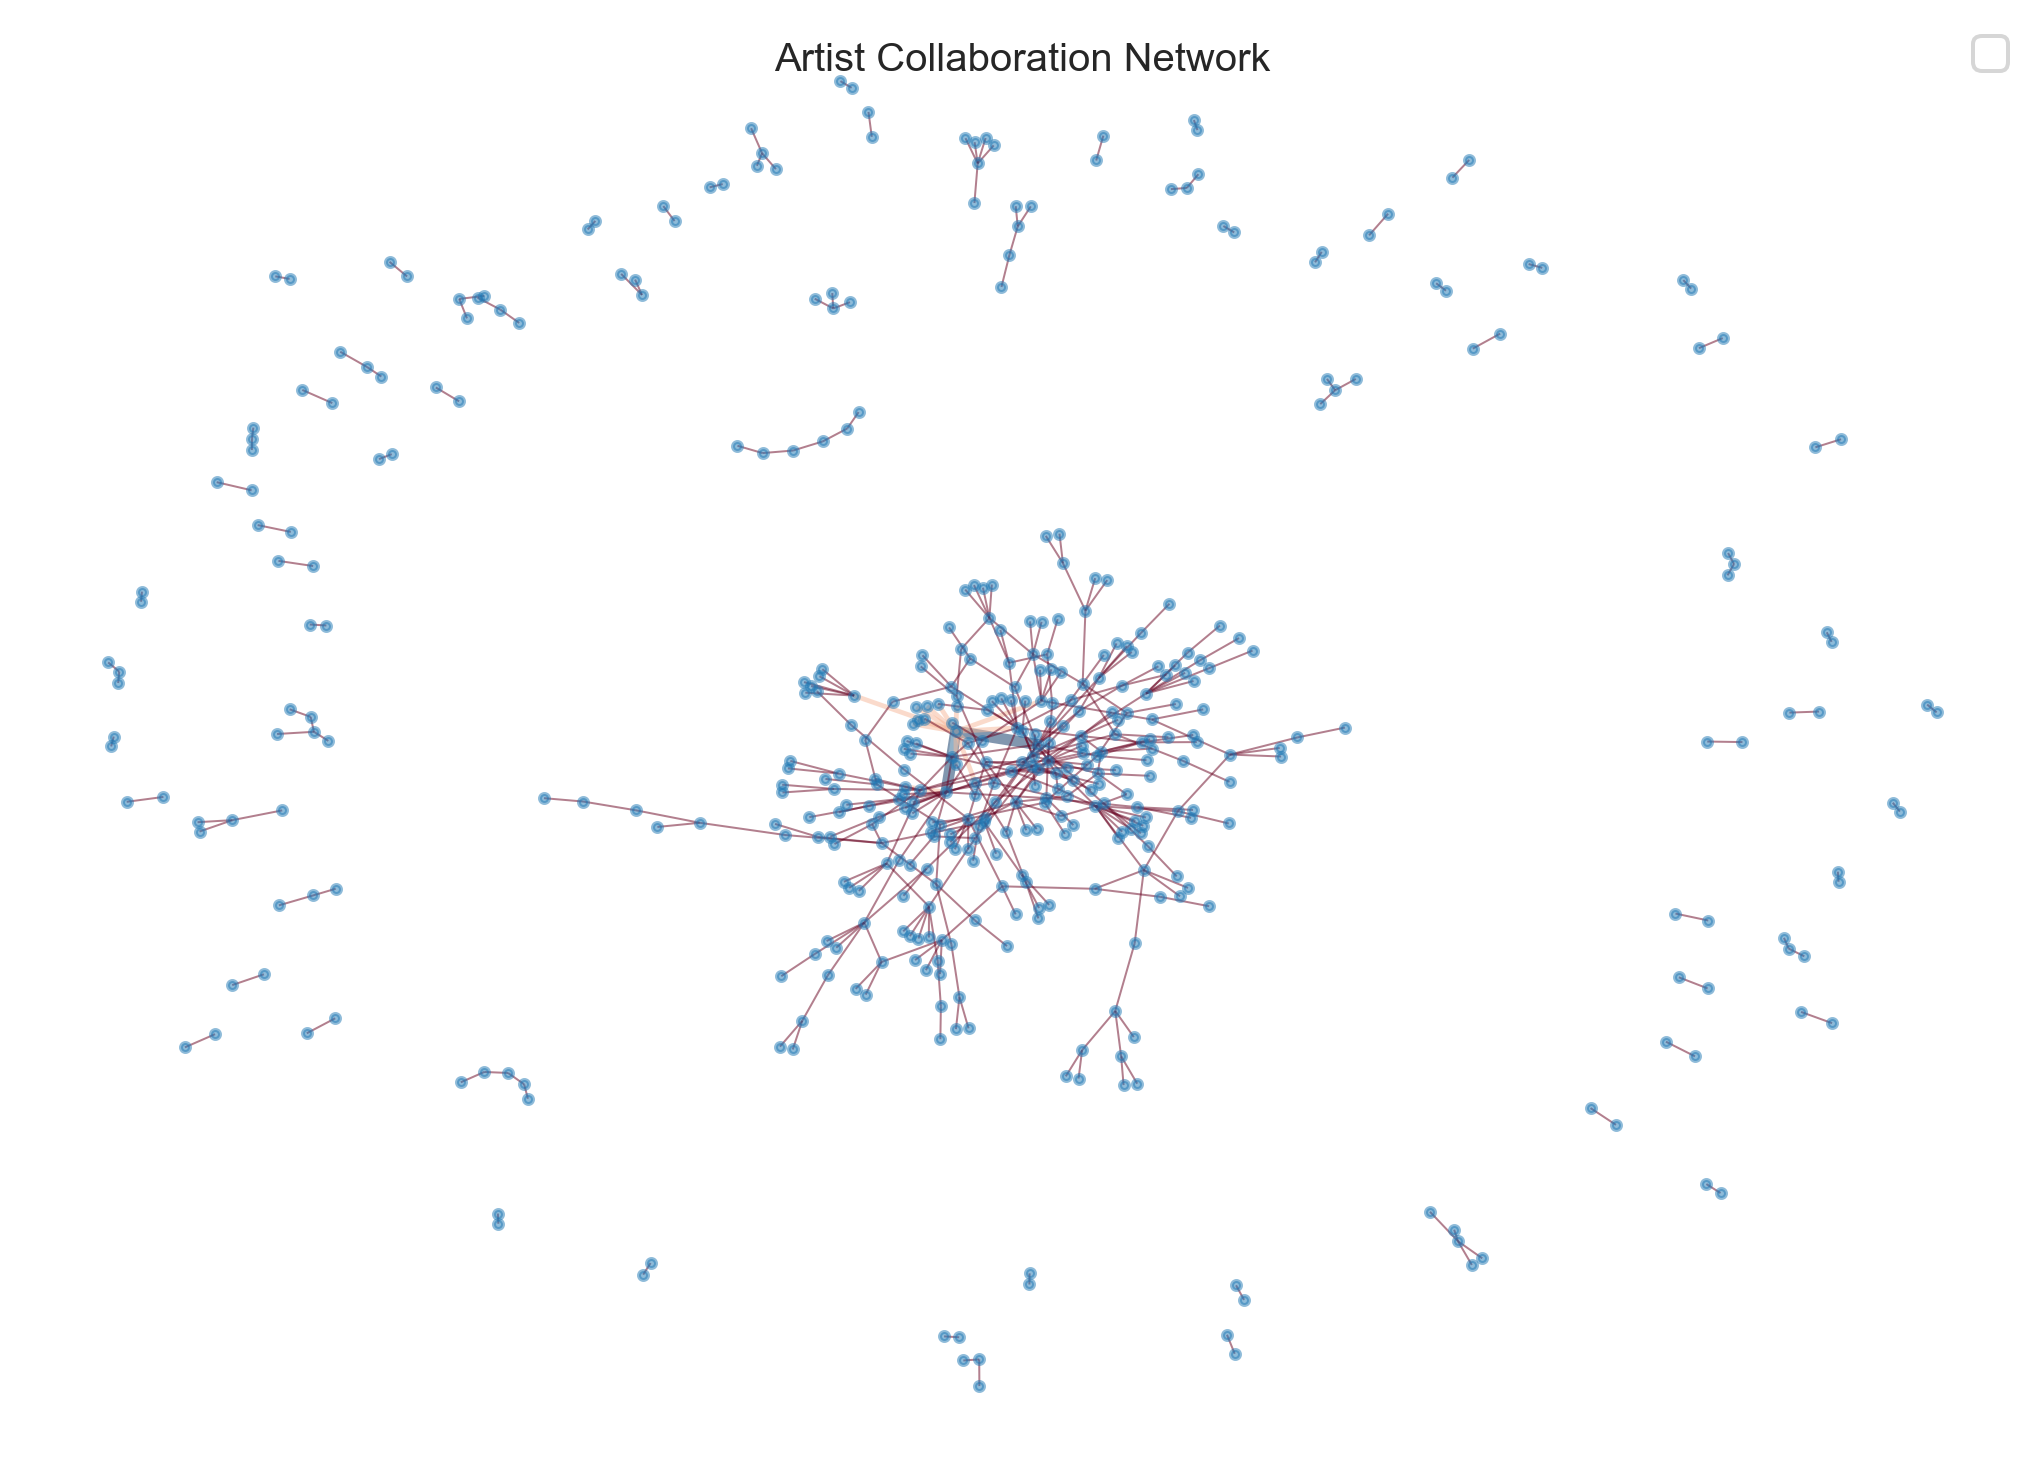

In [11]:
# exclude single-hit artist to simply network visualization
vc = df.artist_clean.value_counts()
exclude = vc[vc == 1].index

# visualize collaborations as undirected edges weighted by frequency
edges = df[df.artist_featured.notnull()][['artist_clean', 'artist_featured']]
u_edges = list()
for index, row in edges.iterrows():
    artist1 = row['artist_clean'].strip()
    artist2 = row['artist_featured'].strip()
    if artist1 in exclude or artist2 in exclude:
        continue
    # to use groupby to obtain weights, must first normalize all artist pairs
    # normalize artist pair by rearranging alphabetically
    new_row = sorted([artist1, artist2])
    u_edges.append(new_row)

# use dummy column of ones and multi-column groupby to obtain edge frequencies
u_edges_df = pd.DataFrame(u_edges)
u_edges_df['one'] = 1
u_edges_df = u_edges_df.groupby([0, 1])['one']\
                       .count().sort_values(ascending=False).reset_index()
u_edges_df.columns = ['artist1', 'artist2', 'degree']

# generate graph. edge width and color is function of frequency (degrees)
degrees = u_edges_df['degree']
u_edges = u_edges_df[['artist1', 'artist2']]
u_edges = u_edges.values.tolist()
graph = nx.Graph(directed=True)
graph.add_edges_from(u_edges)
plt.figure(figsize=(14,10))
nx.draw_spring(graph, node_size=20, edge_color=degrees, edge_cmap=plt.cm.RdBu,
               width=degrees**1.25, alpha=0.5, font_size=5)
plt.suptitle('Artist Collaboration Network', fontsize=20)
plt.legend()

In [12]:
print('total collaborations: {}\n'.format(len(edges)))
print(u_edges_df[u_edges_df.degree > 1])

total collaborations: 611

              artist1               artist2  degree
0               drake             lil wayne       4
1               drake               rihanna       4
2             beyonce                 jay-z       3
3           baby bash             frankie j       2
4             50 cent                  game       2
5         nicki minaj              yo gotti       2
6             ashanti               ja rule       2
7        junior mafia  the notorious b.i.g.       2
8   justin timberlake             timbaland       2
9              eminem               rihanna       2
10           ludacris         missy elliott       2
11         gucci mane                 migos       2
12                eve          gwen stefani       2
13            ja rule        jennifer lopez       2
14       technotronic              ya kid k       2
15      calvin harris               rihanna       2


## Artist longevity

In [13]:
# artist longevity is difference between year of newest hit and oldest hit + 1
longevity = df.groupby('artist_clean').agg({'year': np.ptp})
longevity.columns = ['longevity']

# keep only 30 artists with longest career spans
longevity = longevity.sort_values(by='longevity', ascending=False).head(30)

# get years for newest and oldest hit
min_max_years = df.groupby('artist_clean')['year'].agg([min, max])

# filter billboard song data for only long-career-span artists
timeless = lambda x: True if x in longevity.index else False
timeless_df = df[['artist_clean', 'year']][df['artist_clean'].apply(timeless)]

Text(2011, 28, 'Billboard Year-End\nHot 100 1959-2019')

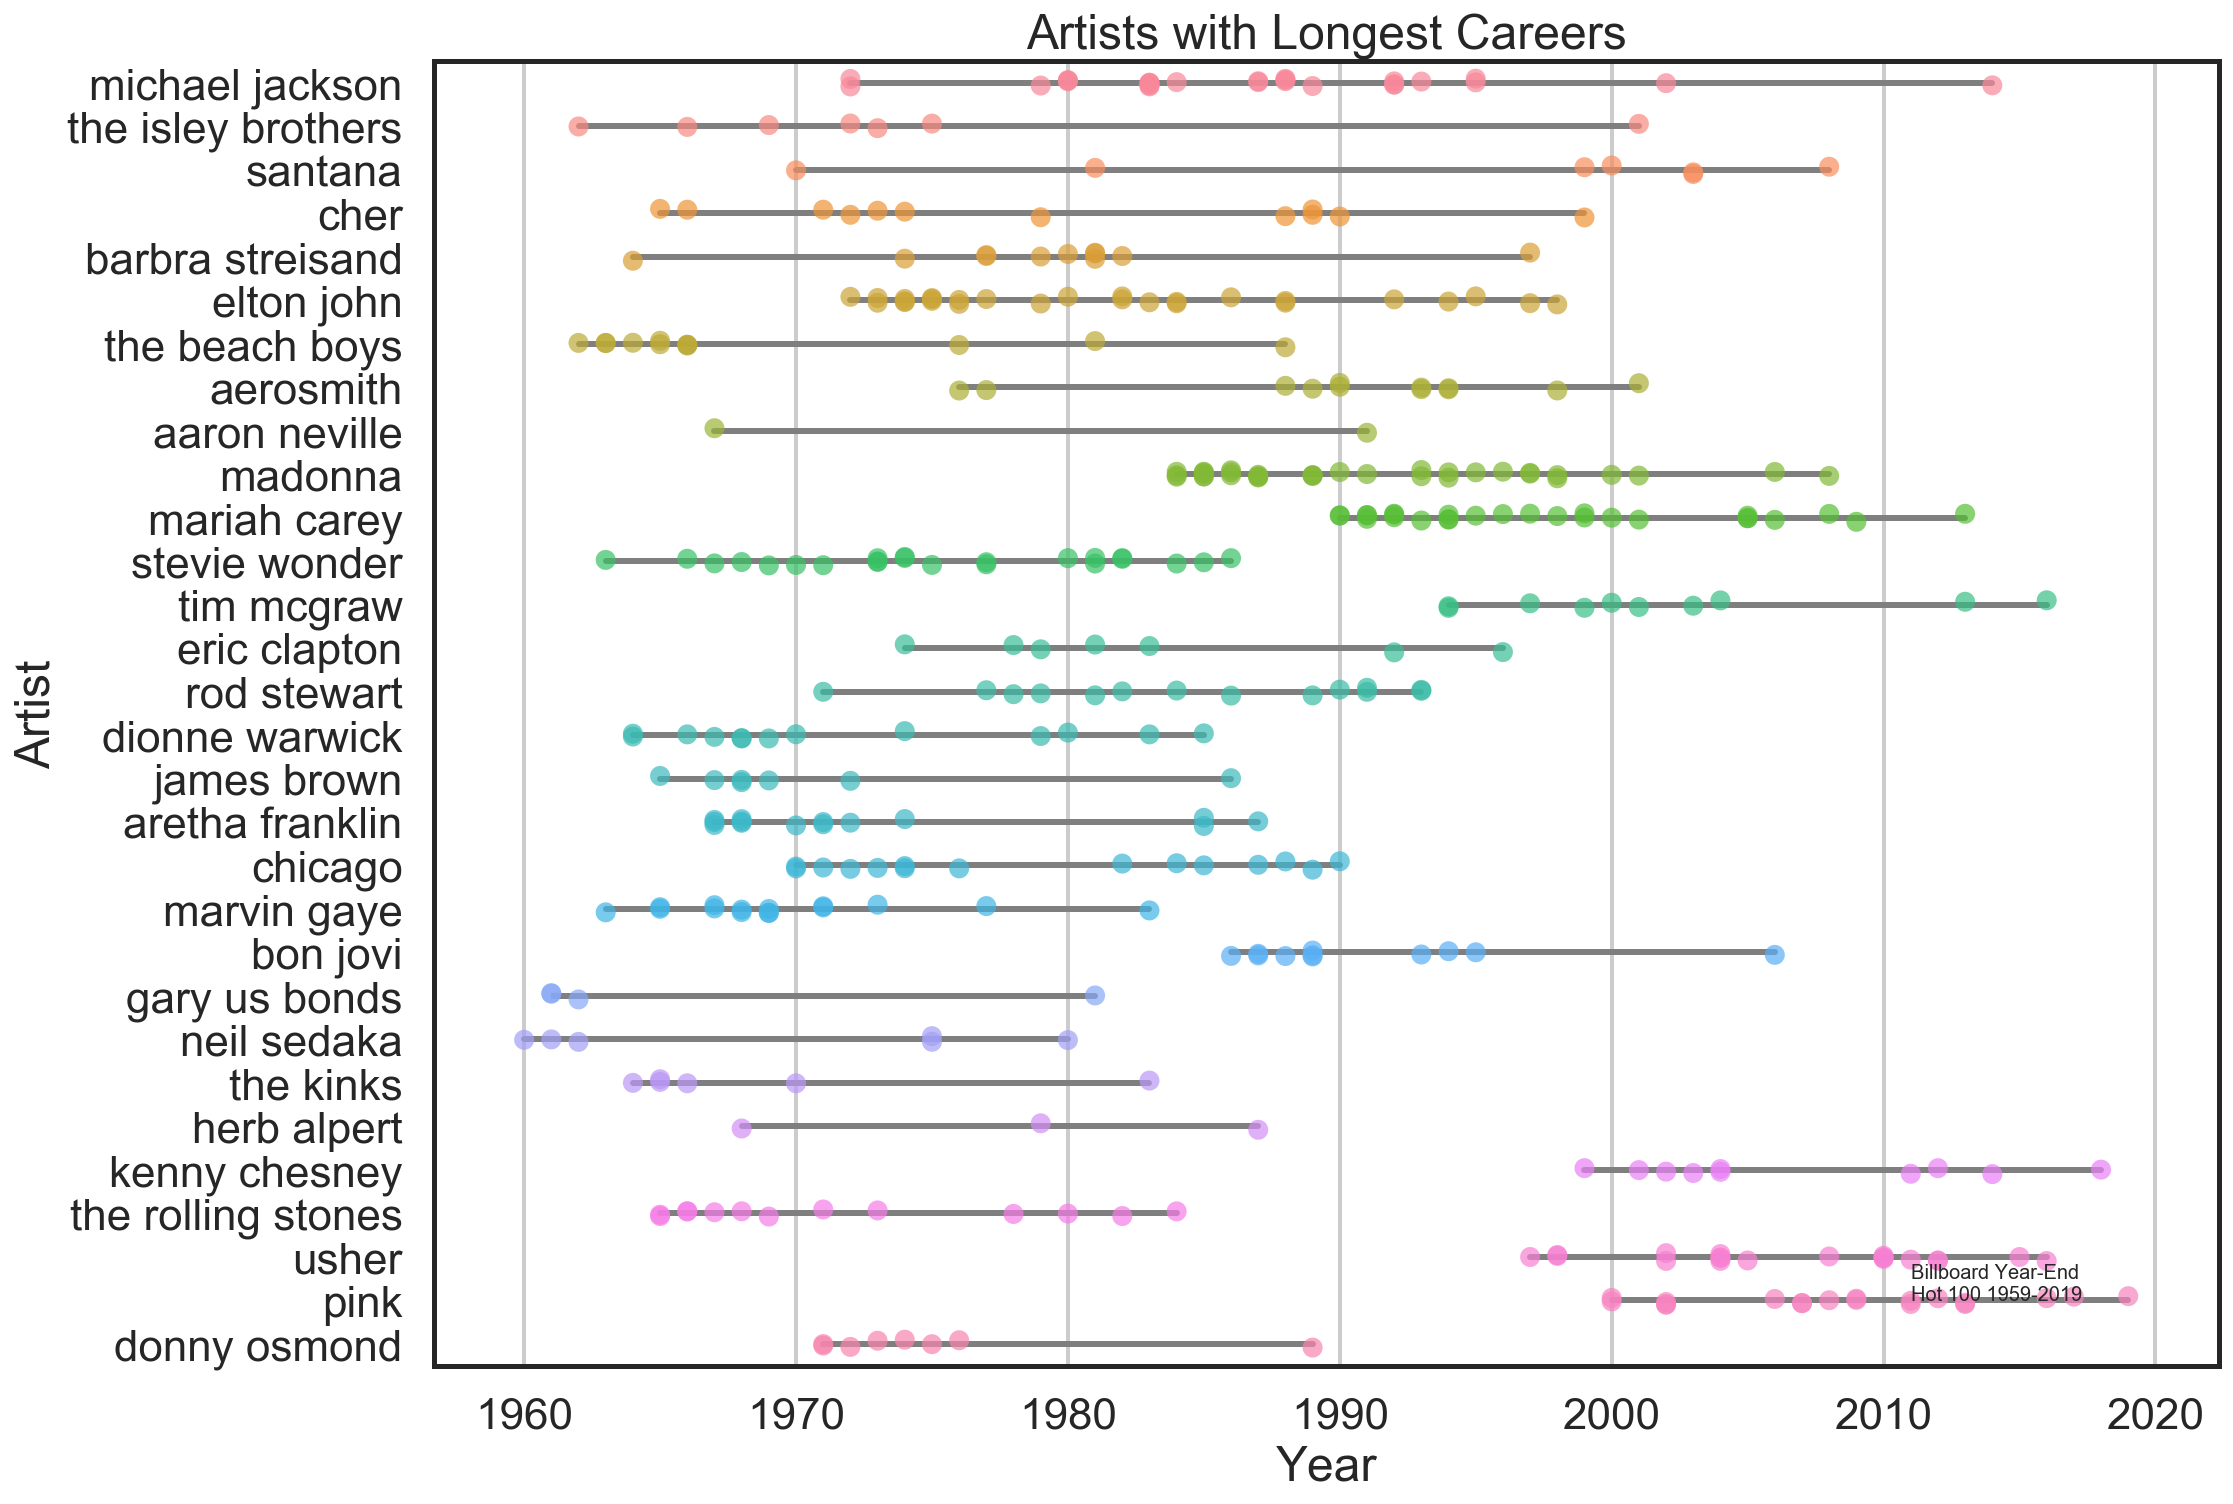

In [14]:
# plot timelines of hits for each artist, ordered by career spans
plt.figure(figsize=(16,12))
ax = sns.stripplot(data=timeless_df, x='year', y='artist_clean', jitter=True, 
              order=longevity.index, size=10, alpha=0.7)
sns.boxplot(data=timeless_df, x='year', y='artist_clean', ax=ax, width=0, whis='range',
            order=longevity.index, color='lightgray')
ax.xaxis.grid(True)
ax.set(ylabel='Artist', xlabel='Year')
ax.set_title('Artists with Longest Careers', fontsize=24)
ax.annotate('Billboard Year-End\nHot 100 1959-2019',
            xy=(2011,28))

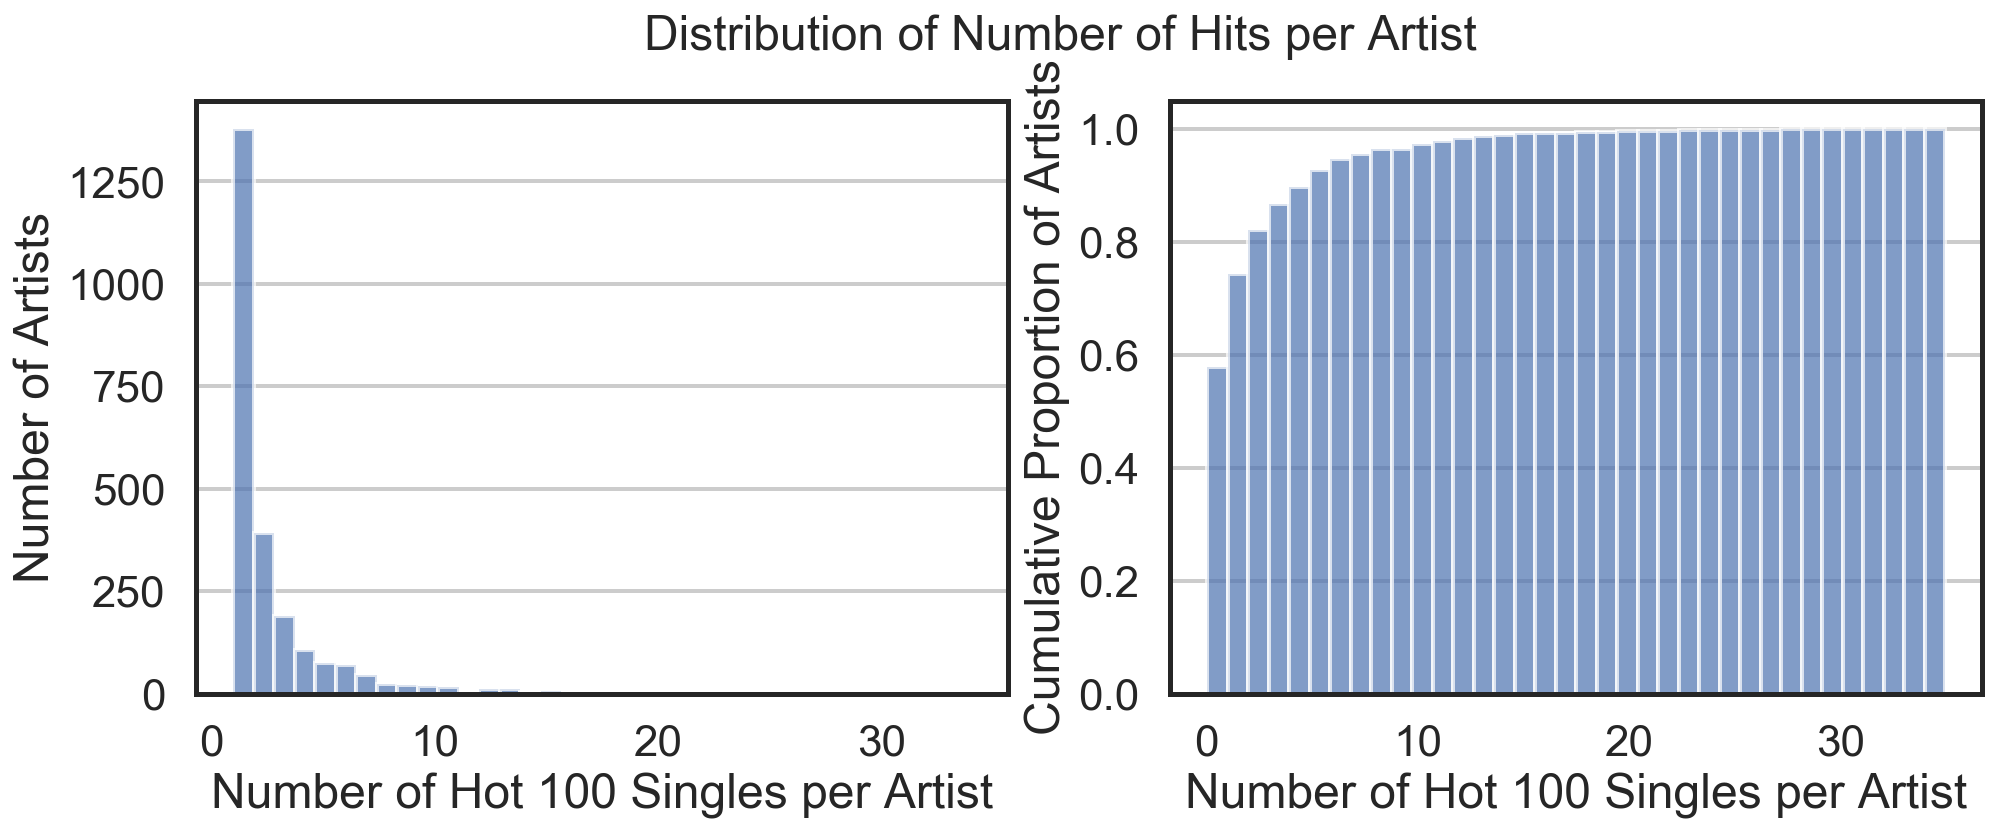

In [15]:
# generate subplots
axes = list()
plt.figure(figsize=(16,12))
grid_positions = [221, 222]
for position in grid_positions:
    axes.append(plt.subplot(position))

# generate upper left histogram
df['artist_clean'].value_counts().plot.hist(bins=36, ax=axes[0], alpha=0.7)
axes[0].set(ylabel='Number of Artists')

# generate upper right cumulative relative frequency histogram
counts = df['artist_clean'].value_counts()
res = relfreq(counts, numbins=36)
x = res.lowerlimit + np.linspace(0, res.binsize*res.frequency.size,
                                 res.frequency.size)
axes[1].bar(x, np.cumsum(res.frequency), width=res.binsize+0.02, alpha=0.7)
axes[1].set(ylabel = 'Cumulative Proportion of Artists')

for ax in axes[:2]:
    ax.set(xlabel='Number of Hot 100 Singles per Artist')
    ax.yaxis.grid(True)

# calculate artist longevity and number of hits per artist
longevity = df.groupby('artist_clean').agg({'year': np.ptp, 'song': len})
longevity.columns = ['longevity', 'n_singles']
longevity['longevity'] = longevity['longevity'] + 1
longevity['hits_per_year'] = longevity['n_singles'] / longevity['longevity']

plt.suptitle('Distribution of Number of Hits per Artist',
             fontsize=24, y=0.93);

In [16]:
(counts <= 3).sum() / len(counts)

0.8214585079631181